Data Collection with CCXT

In [1]:
import ccxt
import pandas as pd

import warnings
warnings.simplefilter("ignore", category=FutureWarning)

# Initialize the exchange
exchange = ccxt.binance()

symbol = 'BTC/USDT'
timeframe = '1d'
since = exchange.parse8601('2021-01-01T00:00:00Z')
now = exchange.milliseconds()

all_candles = []

while since < now:
    candles = exchange.fetch_ohlcv(symbol, timeframe, since)
    if len(candles) == 0:
        break
    since = candles[-1][0] + 1  # start the next fetch from the end of the last one
    all_candles += candles

# Convert to DataFrame
df = pd.DataFrame(all_candles, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['date'] = pd.to_datetime(df['timestamp'], unit='ms')

# Create a copy with the closing price for forecasting
data = df[['date', 'close', 'volume', 'high', 'low']].copy()
data.rename(columns={'date': 'ds', 'close': 'y', 'volume': 'volume', 'high': 'high', 'low': 'low'}, inplace=True)

print(data.head())


          ds         y         volume      high       low
0 2021-01-01  29331.69   54182.925011  29600.00  28624.57
1 2021-01-02  32178.33  129993.873362  33300.00  28946.53
2 2021-01-03  33000.05  120957.566750  34778.11  31962.99
3 2021-01-04  31988.71  140899.885690  33600.00  28130.00
4 2021-01-05  33949.53  116049.997038  34360.00  29900.00


Plot the historical Bitcoin prices

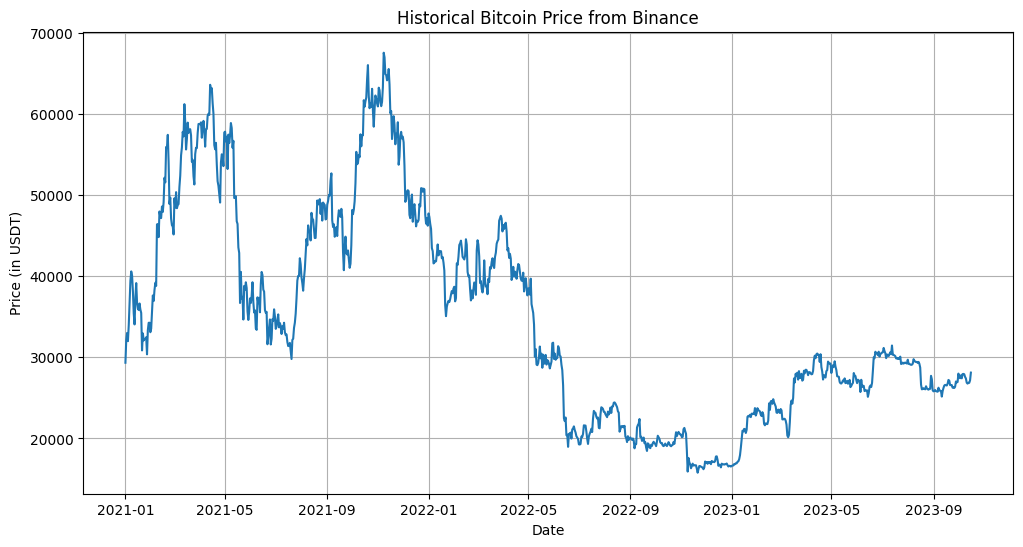

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data['ds'], data['y'])
plt.title('Historical Bitcoin Price from Binance')
plt.xlabel('Date')
plt.ylabel('Price (in USDT)')
plt.grid(True)
plt.show()

Add additional regressors/features & Clean Data

In [3]:
import talib

# Adding short term moving averages
data['ma5'] = data['y'].rolling(window=5).mean()
data['ma10'] = data['y'].rolling(window=10).mean()
data['rsi'] = talib.RSI(data['y'].values, timeperiod=16)
data['obv'] = talib.OBV(data['y'].values, data['volume'].values)
data['macd'], data['signal'], _ = talib.MACD(data['y'].values, fastperiod=12, slowperiod=26, signalperiod=9)

# Stochastic Oscillator
data['k'], data['d'] = talib.STOCH(data['high'].values, data['low'].values, data['y'].values, fastk_period=14, slowk_period=3, slowd_period=3)

# ATR (Average True Range)
data['atr'] = talib.ATR(data['high'].values, data['low'].values, data['y'].values, timeperiod=14)

# Bollinger Bands
data['upper'], data['middle'], data['lower'] = talib.BBANDS(data['y'].values, timeperiod=20)

# Remove NaN rows created due to rolling operations and indicators
data.dropna(inplace=True)

Fit and Train the Prophet model with features/regressors

In [4]:
from prophet import Prophet

# Initialize the Prophet model
model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05
)

# Add regressors for the model
model.add_regressor('rsi')
model.add_regressor('obv')
model.add_regressor('ma5')
model.add_regressor('ma10')
model.add_regressor('macd')
model.add_regressor('signal')
model.add_regressor('k')
model.add_regressor('d')
model.add_regressor('atr')
model.add_regressor('upper')
model.add_regressor('middle')
model.add_regressor('lower')

# Train the model with the data
model.fit(data)

d:\Developer\2023\Python\jupyter-notebooks\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
13:02:03 - cmdstanpy - INFO - Chain [1] start processing
13:02:04 - cmdstanpy - INFO - Chain [1] done processing


Create future date data for which we want to predict the Bitcoin prices and then generate forecasts. Also demonstrate Forecasting with the Regressor/Feature

In [5]:

# Initialize an empty dictionary to hold the forecasts for each indicator
forecasts = {}

# List of all TA indicators
indicators = ['ma5', 'ma10', 'rsi', 'obv', 'macd', 'signal', 'k', 'd', 'atr', 'upper', 'middle', 'lower']

# Loop through each indicator to forecast it
for indicator in indicators:
    # Prepare DataFrame for Prophet
    ind_df = data[['ds', indicator]].dropna()
    ind_df.rename(columns={indicator: 'y'}, inplace=True)
    
    # Initialize and fit Prophet model
    ind_model = Prophet()
    ind_model.fit(ind_df)
    
    # Make future DataFrame and forecast
    ind_future = ind_model.make_future_dataframe(periods=365)
    ind_forecast = ind_model.predict(ind_future)
    
    # Store the forecast in the dictionary
    forecasts[indicator] = ind_forecast['yhat']

# Prepare the main future DataFrame
main_future = model.make_future_dataframe(periods=365)

# Add the forecasted values of each indicator to the main future DataFrame
for indicator in indicators:
    main_future[indicator] = forecasts[indicator]

# Now you can proceed with the main Prophet model's prediction
main_forecast = model.predict(main_future)

13:02:04 - cmdstanpy - INFO - Chain [1] start processing
13:02:05 - cmdstanpy - INFO - Chain [1] done processing
13:02:05 - cmdstanpy - INFO - Chain [1] start processing
13:02:05 - cmdstanpy - INFO - Chain [1] done processing
13:02:05 - cmdstanpy - INFO - Chain [1] start processing
13:02:06 - cmdstanpy - INFO - Chain [1] done processing
13:02:06 - cmdstanpy - INFO - Chain [1] start processing
13:02:06 - cmdstanpy - INFO - Chain [1] done processing
13:02:06 - cmdstanpy - INFO - Chain [1] start processing
13:02:06 - cmdstanpy - INFO - Chain [1] done processing
13:02:07 - cmdstanpy - INFO - Chain [1] start processing
13:02:07 - cmdstanpy - INFO - Chain [1] done processing
13:02:07 - cmdstanpy - INFO - Chain [1] start processing
13:02:07 - cmdstanpy - INFO - Chain [1] done processing
13:02:08 - cmdstanpy - INFO - Chain [1] start processing
13:02:08 - cmdstanpy - INFO - Chain [1] done processing
13:02:08 - cmdstanpy - INFO - Chain [1] start processing
13:02:08 - cmdstanpy - INFO - Chain [1]

Predict the price for the next day

In [6]:
# Predict Bitcoin price for the next day
future_day = model.make_future_dataframe(periods=1, freq='D', include_history=False)

# Use the first forecasted value for each TA indicator for the next day
for indicator in indicators:
    next_day_value = forecasts[indicator].iloc[0]
    future_day[indicator] = next_day_value

# Generate the one-day-ahead forecast
forecast_day = model.predict(future_day)
next_day_price = forecast_day['yhat'].values[0]
print(f"Predicted Bitcoin price for the next day: ${next_day_price:.2f}")

Predicted Bitcoin price for the next day: $37738.72


Visualize the predicted prices

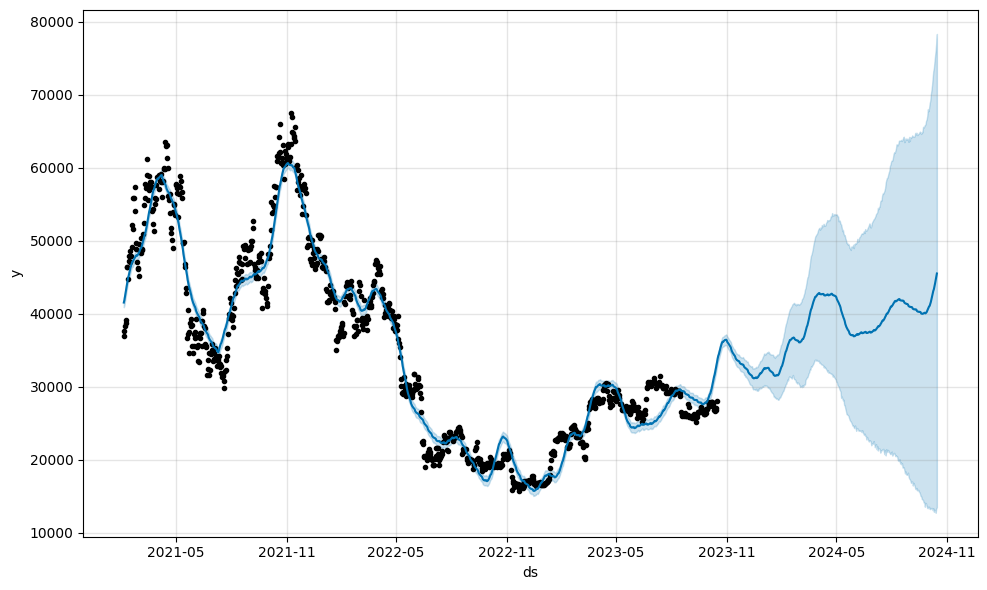

In [7]:
fig1 = model.plot(main_forecast)

 Break down the forecast into its various components

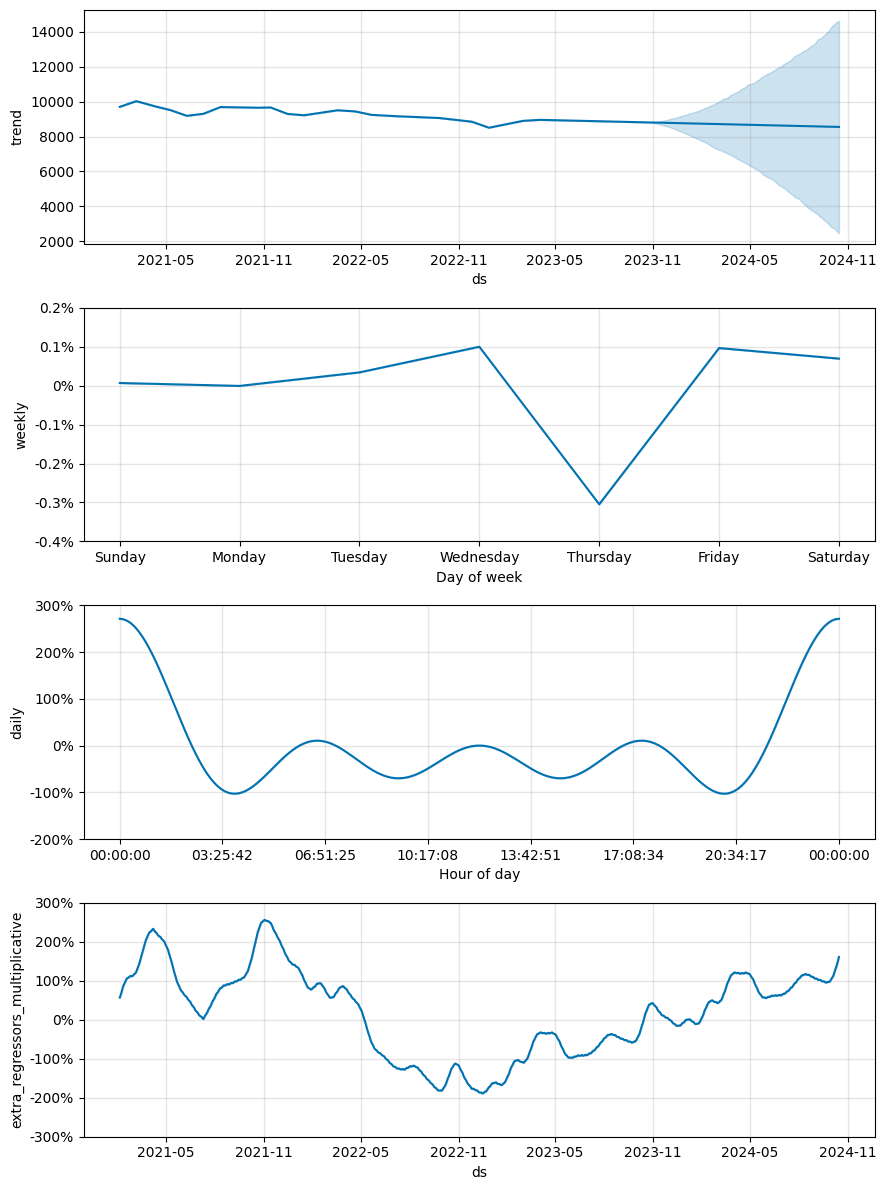

In [8]:
fig2 = model.plot_components(main_forecast)

Setup & Perform Cross-Validation

In [9]:
from prophet.diagnostics import cross_validation

# Here's an example setup:
# Initial training period = 730 days (2 years)
# Horizon = 90 days
# Period = 30 days (i.e., make a forecast every 30 days)

df_cv = cross_validation(model, initial='730 days', period='30 days', horizon='90 days')

  0%|          | 0/6 [00:00<?, ?it/s]13:02:12 - cmdstanpy - INFO - Chain [1] start processing
13:02:12 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.42it/s]13:02:13 - cmdstanpy - INFO - Chain [1] start processing
13:02:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.40it/s]13:02:13 - cmdstanpy - INFO - Chain [1] start processing
13:02:14 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:02<00:02,  1.30it/s]13:02:14 - cmdstanpy - INFO - Chain [1] start processing
13:02:15 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:03<00:01,  1.09it/s]13:02:15 - cmdstanpy - INFO - Chain [1] start processing
13:02:16 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:04<00:00,  1.21it/s]13:02:16 - cmdstanpy - INFO - Chain [1] start processing
13:02:16 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 6/6 [00:04<00:00,  1.23it/s]


Compute Performance Metrics

In [10]:
from prophet.diagnostics import performance_metrics

df_p = performance_metrics(df_cv)
print(df_p.head())

  horizon            mse        rmse         mae      mape     mdape  \
0  9 days  791286.882800  889.543075  739.884518  0.027295  0.023283   
1 10 days  833860.230936  913.159477  767.749087  0.028236  0.025139   
2 11 days  853816.669876  924.022007  785.867052  0.028819  0.026761   
3 12 days  840955.781227  917.036412  779.498033  0.028559  0.024398   
4 13 days  813697.694007  902.051935  769.679235  0.028196  0.024398   

      smape  coverage  
0  0.027448  0.537037  
1  0.028366  0.500000  
2  0.028931  0.500000  
3  0.028645  0.518519  
4  0.028281  0.518519  


Visualizing Performance

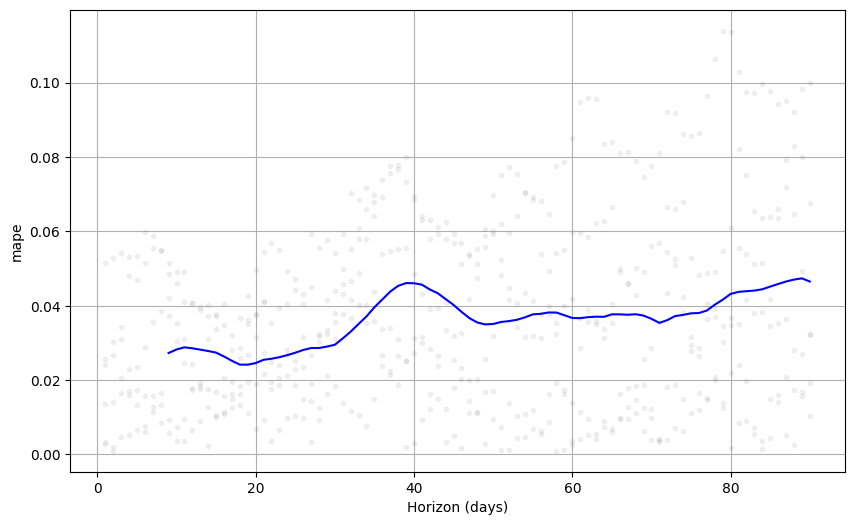

In [11]:
from prophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv, metric='mape')

Compute the percentage accuracy from MAPE

In [12]:
# Assuming df_p is the result from the performance_metrics function
mape = df_p['mape'].mean()
accuracy = 100 - (mape * 100)
print(f"Forecast Accuracy: {accuracy:.2f}%")

Forecast Accuracy: 96.37%
